**Тема курсовой работы: "Машинное обучение в задачах идентификации личности по голосу"**

**Цель**:

Исследовать возможности машинного обучения в задаче различения голосов, созданных искусственным интеллектом, от записей реальных людей.

**Задачи**:

1) Собрать датасет, содержащий как реальные голоса, так и голоса, сгенерированные нейронной сетью.

2) Предобработать аудиоданные для обеспечения их единообразия и качества.

3) Изучить различные методы машинного обучения, подходящие для задачи распознавания фейковых голосов.

4) Выбрать и обучить подходящую модель машинного обучения, например, сверточную нейронную сеть (CNN).

5) Оценить производительность модели на тестовой выборке, а также проанализировать результаты и внести коррективы в модель при необходимости.

6) Сделать выводы о способности модели машинного обучения отличать сгенерированные голоса от реальных.


**Датасет**: https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition/data



# Описание датасета

Набор данных DEEP-VOICE. DEEP-VOICE состоит из реальной человеческой речи восьми известных людей, и их речи преобразованы друг в друга с помощью Retrieval-based Voice Conversion.

Для каждой аудиозаписи перед преобразованием с помощью RVC было удалено сопровождение ("фоновый шум"). Затем к Deep Fake речи добавляется оригинальный шум.

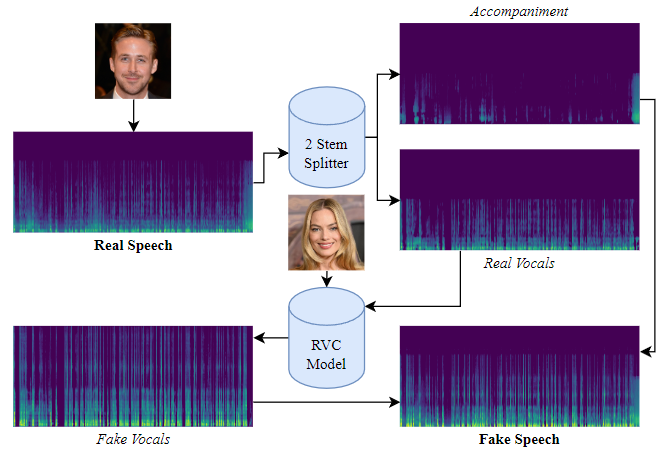

Источник изображения: https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition

Исходные аудиозаписи можно найти в каталоге "AUDIO". Они расположены в каталогах классов "REAL" и "FAKE". В названиях аудиофайлов указано, какие дикторы передавали реальную речь и в какие голоса они были преобразованы. Например, "Обама-Байдену" означает, что речь Барака Обамы была преобразована в голос Джо Байдена.

In [114]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            f1_score, matthews_corrcoef, roc_auc_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix
import os
import librosa
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
import IPython
import warnings

# Описание данных

In [103]:
print("Пример реального голоса (Linus Sebastian):")
IPython.display.Audio("/kaggle/input/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3")

Пример реального голоса (Linus Sebastian):


In [106]:
print("Пример сгенерированной записи (Linus в Elon Musk):")
IPython.display.Audio("/kaggle/input/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3")

Пример сгенерированной записи (Linus в Elon Musk):


Наши данные представлены в аудиоформате. И есть два пути решения задачи:
1) Написать нейронную сеть, которая бы обрабатывала бы спектрограммы изображений
2) Сделать преобразование в табличные данные и уже применять классическое машинное обучение.

Я выбрал 2 путь, поскольку явно ускоряет процесс разработки, а также получения результатов, при этом не факт, что будет потеря в качестве модели. 



**Важное замечение**: в самом датасете уже представлена необходимая таблица с характеристиками, однако она не подходит, поскольку по ней нельзя получить хорошую валидацию. Каждую запись нужно разделить на фрагменты одной длительности (3-7 секунд) и уже на основе этих сегментов обучать модель. Однако любые два сегмента из одной и той же дорожки не могут быть одновременно представлены в тестовой и тренировочной выборке. Необходимо, чтобы модель не видела никогда данный аудиофайл, тогда будут честные результаты на тесовой выборке. Поэтому необходимо самостоятельно сделать датасет нужной размерности и с нужными параметрами.

# Генерация датасета

In [2]:
# Извлечение фичей из аудиозаписи
def extract_features(file_path, segment_length, file_name):
    try:
        # Загружаем файл
        y, sr = librosa.load(file_path)
        # Считаем количество сегментов каждой записи
        num_segments = int(np.ceil(len(y) / float(segment_length * sr)))

    
        features = []

        # Достаем все возможные фичи
        for i in range(num_segments):
            # Считаем начало и конец сегмента
            start_frame = i * segment_length * sr
            end_frame = min(len(y), (i + 1) * segment_length * sr)
            
            # Выбираем нужный фрагмент
            y_segment = y[start_frame:end_frame]

            chroma_stft = np.mean(librosa.feature.chroma_stft(y=y_segment, sr=sr))
            rms = np.mean(librosa.feature.rms(y=y_segment))
            spec_cent = np.mean(librosa.feature.spectral_centroid(y=y_segment, sr=sr))
            spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y_segment, sr=sr))
            rolloff = np.mean(librosa.feature.spectral_rolloff(y=y_segment, sr=sr))
            zcr = np.mean(librosa.feature.zero_crossing_rate(y_segment))
            mfccs = librosa.feature.mfcc(y=y_segment, sr=sr)
            mfccs_mean = np.mean(mfccs, axis=1)
            
            # Добавляем все фичи в массив
            features.append([chroma_stft, rms, spec_cent, spec_bw, rolloff, zcr, *mfccs_mean, file_name])

        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

#  Функция которая уже и создает нужный датасет
def create_dataset(audio_dir, segment_length):
    labels = ['FAKE', 'REAL']
    feature_list = []

    for label in labels:
        print(f'Processing {label} files...')
        files = os.listdir(os.path.join(audio_dir, label))
    
        for file in files:
            file_path = os.path.join(audio_dir, label, file)
        
            file_name = os.path.splitext(file)[0]
            # Достаем фичи для данного файла
            file_features = extract_features(file_path, segment_length, file_name)
            if file_features:
                for segment_features in file_features:
                    feature_list.append(segment_features + [label])
                    
    df = pd.DataFrame(feature_list, columns=['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'origin_sample', 'LABEL'])
    
    return df

In [3]:
use_names = ['FAKE','REAL']
CLASSES = [i for i in range(len(use_names))]
CLASSES = [0, 1]
def find_index(name):
    return use_names.index(name)
def get_names():
    return use_names
def get_classes():
    return CLASSES

# Загрузка данных

In [107]:

audio_dir = '/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO'

# Задаем длительность каждого кусочка. Я выбрал 5 секунд, как оптимальный вариант
segment_length = 5 

df = create_dataset(audio_dir, segment_length)

In [108]:
df.to_csv('voice-deepfake.csv') # сохраняем датасет, чтобы можно им потом пользоваться и каждый раз не добавлять фичи

In [109]:
df = pd.read_csv('/kaggle/input/voice-deepfake-segmented/voice-deepfake.csv').iloc[:, 1:]

Мы получили важный столбец origin_sample, который говорит из какого именно файла был взят сегмент.

In [110]:
# df = pd.read_csv('/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/DATASET-balanced.csv')
df.shape

(6005, 28)

In [111]:
df.head(10)

chroma_stft       rms  spectral_centroid  spectral_bandwidth      rolloff  \
0     0.382507  0.051161        2390.066669         2177.883221  4412.711589   
1     0.460081  0.027345        2112.921340         1835.604716  3651.472982   
2     0.319919  0.073808        2301.842925         1904.540153  3977.810669   
3     0.320805  0.045280        1820.944549         1965.102218  3499.444580   
4     0.329760  0.048822        1846.248384         1926.211491  3370.743815   
5     0.412580  0.024338        2548.278325         2113.522149  4658.000692   
6     0.364129  0.061467        2045.047156         1979.706430  3732.571411   
7     0.374114  0.042918        1692.046293         1977.605450  3219.612630   
8     0.379902  0.039742        2360.117194         2111.140912  4331.513468   
9     0.418187  0.057098        2610.143160         2195.390450  4739.747111   

   zero_crossing_rate      mfcc1       mfcc2      mfcc3      mfcc4  ...  \
0            0.133640 -296.96448   82.385056  -4.131142  13.126677  ...   
1            0.126209 -247.57024   95.260240 -75.654720 -24.393559  ...   
2            0.138550 -244.87196   88.696360 -23.622404   1.745956  ...   
3            0.082522 -297.20602  116.537900 -17.635122   4.880865  ...   
4            0.088619 -289.27567  111.706980 -15.895399  15.544977  ...   
5            0.150635 -225.34860   70.795710 -67.567040 -10.593250  ...   
6            0.110566 -298.03757   94.670060 -21.626694   4.632839  ...   
7            0.069897 -352.01166  116.795470   3.396342  20.017662  ...   
8            0.136240 -275.48557   92.577490 -10.661176  15.478199  ...   
9            0.159245 -245.61867   74.101190 -31.691404  -2.122098  ...   

     mfcc13    mfcc14     mfcc15    mfcc16    mfcc17    mfcc18    mfcc19  \
0 -4.999927 -1.794277  -7.252969  0.003172 -4.505654 -2.605229 -5.075643   
1 -4.497469  1.045735  -2.561162 -1.316598 -6.148734  3.699545  0.923580   
2 -7.424571  0.072108  -7.030684 -0.773428 -5.891437 -0.660559 -3.251126   
3 -4.752608  1.243125  -8.386904  0.178788 -7.545589 -1.507603 -4.275387   
4 -2.557486 -4.195044 -11.466291 -2.611061 -7.194823  1.092692 -4.691645   
5 -0.948591 -0.284542  -1.832254  2.915251 -4.188355  1.587563 -1.232715   
6 -2.572112  0.172738  -7.097357 -0.567016 -4.734948 -0.120984 -4.169175   
7 -4.132605 -0.547788  -6.504232  0.037450 -5.328571 -0.603535 -4.311264   
8 -7.764298  2.128254  -6.262150 -0.198683 -3.380972  1.981988 -7.995663   
9 -8.702359  1.795904  -7.358803 -0.684008 -3.051163  1.266629 -7.402658   

     mfcc20   origin_sample  LABEL  
0 -0.067520  trump-to-Obama   FAKE  
1  7.462750  trump-to-Obama   FAKE  
2 -1.123671  trump-to-Obama   FAKE  
3  0.140748  trump-to-Obama   FAKE  
4 -0.790561  trump-to-Obama   FAKE  
5  1.791206  trump-to-Obama   FAKE  
6 -1.119672  trump-to-Obama   FAKE  
7 -1.435148  trump-to-Obama   FAKE  
8  0.383134  trump-to-Obama   FAKE  
9 -1.548516  trump-to-Obama   FAKE  

[10 rows x 28 columns]

1. chroma_stft: Хромограмма во временной области. Это представление питча звука в течение времени.

2. rms: Среднеквадратичное значение аудиосигнала. Это мера мощности звука.

3. spectral_centroid: Средневзвешенное среднее всех частот, присутствующих в звуковом сигнале. Это мера "яркости" звука.

4. spectral_bandwidth: Диапазон частот, в котором происходит большая часть энергии звука.

5. rolloff: Частота ниже которой находится определенный процент общей энергии спектра.

6. zero_crossing_rate: Скорость, с которой сигнал меняет знак. Это мера шумов в звуке.

7. mfcc1 - mfcc20: Мел-кепстральные коэффициенты. Это набор признаков, которые описывают общую форму спектра мощности звука. Они широко используются в распознавании речи и звуков, так как они могут ловко улавливать характеристики звуков, важные для человеческого слуха. В общем случае, более низкие коэффициенты (например, mfcc1, mfcc2) коррелируют с более грубыми характеристиками звука, такими как общая высота тона и громкость. Более высокие коэффициенты (например, mfcc19, mfcc20) могут описывать более тонкие детали звука, такие как тембр.

In [112]:
df.dtypes # проверка соответсвия типов

chroma_stft           float64
rms                   float64
spectral_centroid     float64
spectral_bandwidth    float64
rolloff               float64
zero_crossing_rate    float64
mfcc1                 float64
mfcc2                 float64
mfcc3                 float64
mfcc4                 float64
mfcc5                 float64
mfcc6                 float64
mfcc7                 float64
mfcc8                 float64
mfcc9                 float64
mfcc10                float64
mfcc11                float64
mfcc12                float64
mfcc13                float64
mfcc14                float64
mfcc15                float64
mfcc16                float64
mfcc17                float64
mfcc18                float64
mfcc19                float64
mfcc20                float64
origin_sample          object
LABEL                  object
dtype: object

In [124]:
df.info() # у нас нет нулевых значений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6005 entries, 0 to 6004
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   chroma_stft         6005 non-null   float64
 1   rms                 6005 non-null   float64
 2   spectral_centroid   6005 non-null   float64
 3   spectral_bandwidth  6005 non-null   float64
 4   rolloff             6005 non-null   float64
 5   zero_crossing_rate  6005 non-null   float64
 6   mfcc1               6005 non-null   float64
 7   mfcc2               6005 non-null   float64
 8   mfcc3               6005 non-null   float64
 9   mfcc4               6005 non-null   float64
 10  mfcc5               6005 non-null   float64
 11  mfcc6               6005 non-null   float64
 12  mfcc7               6005 non-null   float64
 13  mfcc8               6005 non-null   float64
 14  mfcc9               6005 non-null   float64
 15  mfcc10              6005 non-null   float64
 16  mfcc11

In [123]:
df.describe()

chroma_stft          rms  spectral_centroid  spectral_bandwidth  \
count  6005.000000  6005.000000        6005.000000         6005.000000   
mean      0.394862     0.047941        2293.215906         2134.250959   
std       0.057795     0.026056         531.457654          339.838373   
min       0.223032     0.001693         832.855779          899.252587   
25%       0.354650     0.028550        1916.329218         1908.066974   
50%       0.391770     0.046444        2217.326107         2134.919257   
75%       0.431343     0.064563        2620.071818         2385.693768   
max       0.665261     0.159286        4651.969470         3094.170633   

           rolloff  zero_crossing_rate        mfcc1        mfcc2        mfcc3  \
count  6005.000000         6005.000000  6005.000000  6005.000000  6005.000000   
mean   4227.955216            0.127395  -307.139803    90.925529   -11.410484   
std    1006.799234            0.042416    65.869815    26.964806    22.738730   
min    1538.377889            0.009277  -582.558840     8.684763  -107.199080   
25%    3491.269938            0.097426  -342.530000    73.102150   -22.745120   
50%    4119.670614            0.118286  -294.248380    91.730286    -5.708620   
75%    4876.522827            0.150280  -260.006500   107.918594     4.446939   
max    8013.043213            0.309306  -145.615400   199.076680    43.838700   

             mfcc4  ...       mfcc11       mfcc12       mfcc13       mfcc14  \
count  6005.000000  ...  6005.000000  6005.000000  6005.000000  6005.000000   
mean     11.337881  ...    -5.794000    -2.457796    -4.715798    -2.523643   
std      14.577842  ...     5.937282     4.773905     4.084579     4.843675   
min     -37.360443  ...   -27.714201   -23.404903   -21.478611   -18.768652   
25%       1.702977  ...    -9.709704    -5.508456    -7.495933    -5.514584   
50%      13.508973  ...    -5.718627    -2.559251    -4.819162    -2.194573   
75%      21.852480  ...    -1.656646     0.414206    -1.811143     0.622604   
max      55.227790  ...    11.624536    15.245011    11.145122    23.336792   

            mfcc15       mfcc16       mfcc17       mfcc18       mfcc19  \
count  6005.000000  6005.000000  6005.000000  6005.000000  6005.000000   
mean     -5.230708    -2.841038    -7.000386    -2.534124    -5.072861   
std       4.133775     6.074694     4.010585     3.088501     3.902963   
min     -17.647402   -25.218334   -20.612597   -13.176586   -19.717660   
25%      -8.016097    -5.400042    -9.734614    -4.626361    -7.470627   
50%      -5.646479    -1.495485    -6.825666    -2.900718    -4.945238   
75%      -2.752098     1.183953    -4.281013    -0.917692    -2.593842   
max       9.776768    10.752590    10.130178    12.001943     7.103205   

            mfcc20  
count  6005.000000  
mean     -2.546614  
std       3.956479  
min     -16.433779  
25%      -5.429666  
50%      -2.705293  
75%       0.011943  
max      11.636910  

[8 rows x 26 columns]

В целом разброс данных не очень велик, что хорошо.

# Визуализация данных

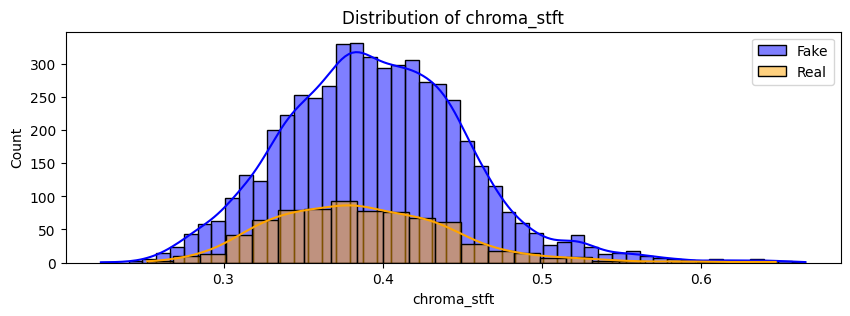

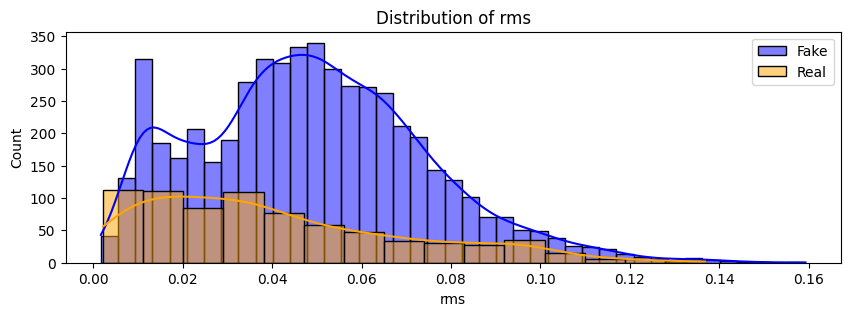

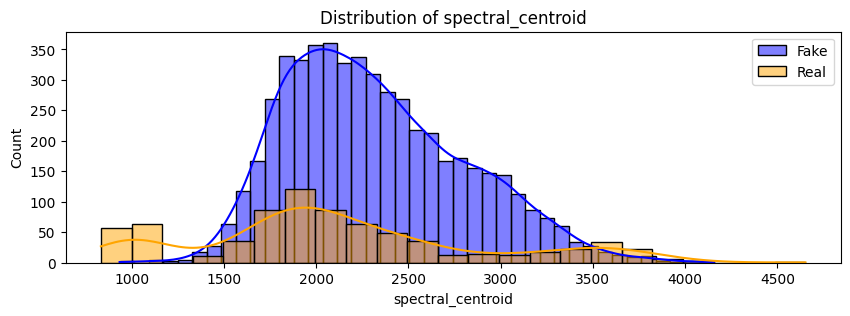

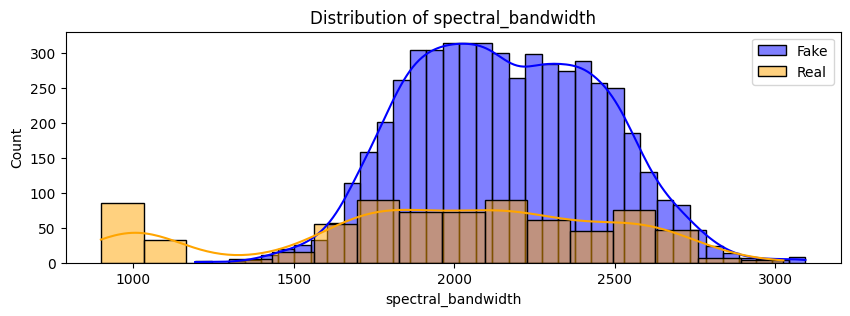

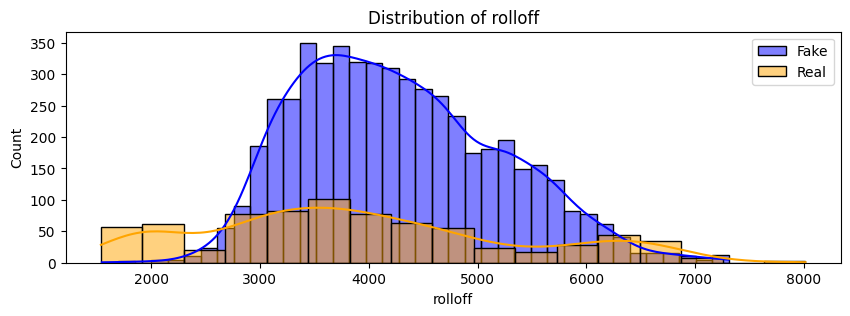

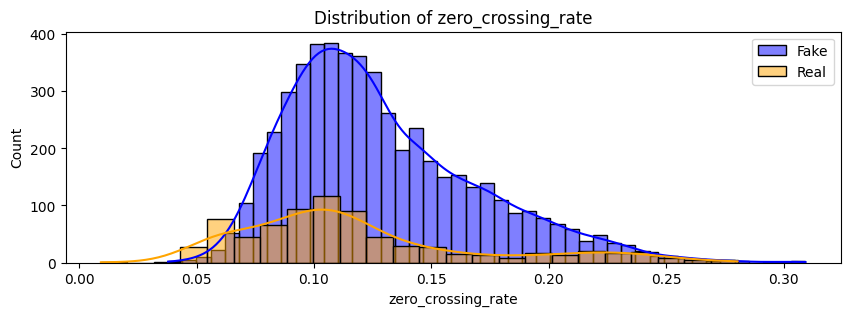

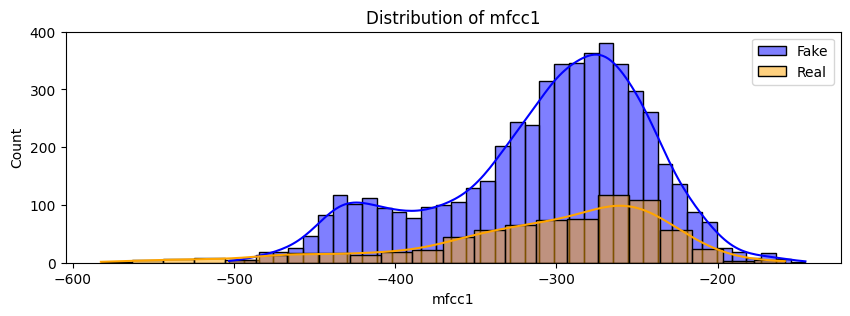

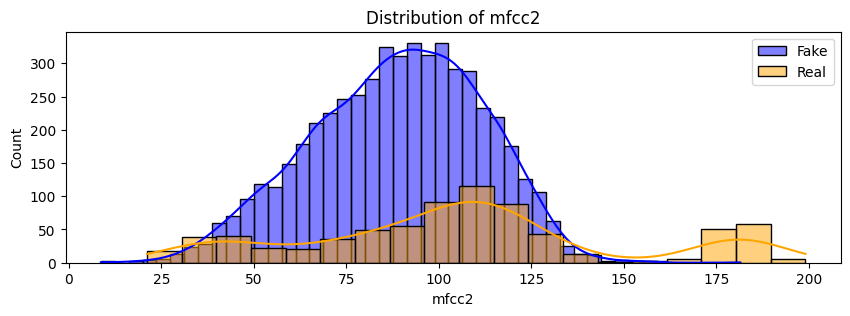

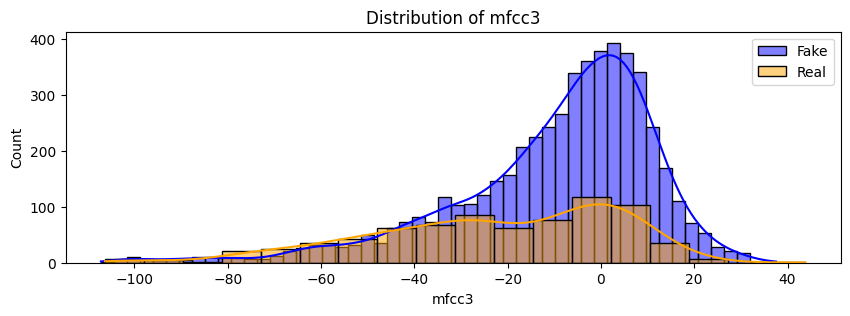

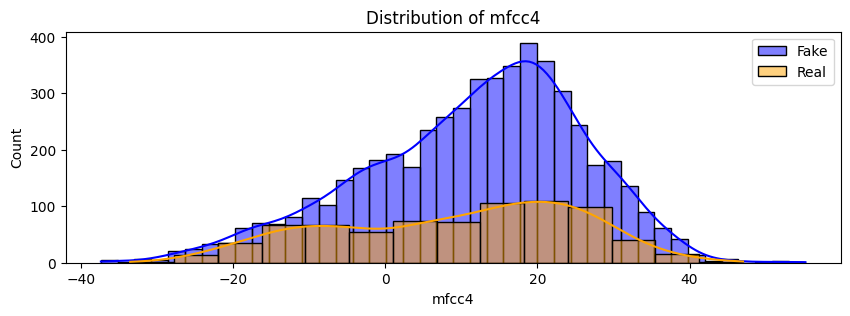

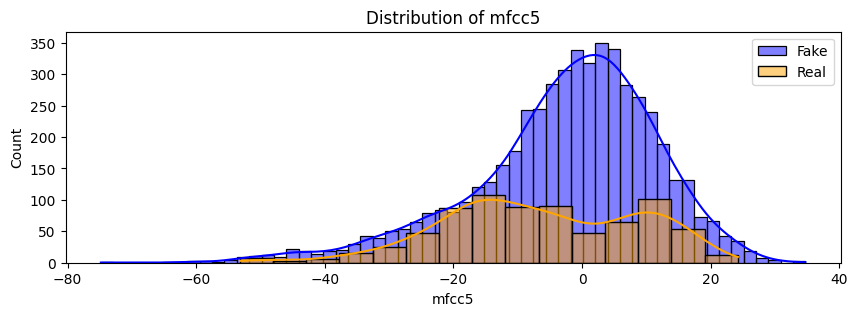

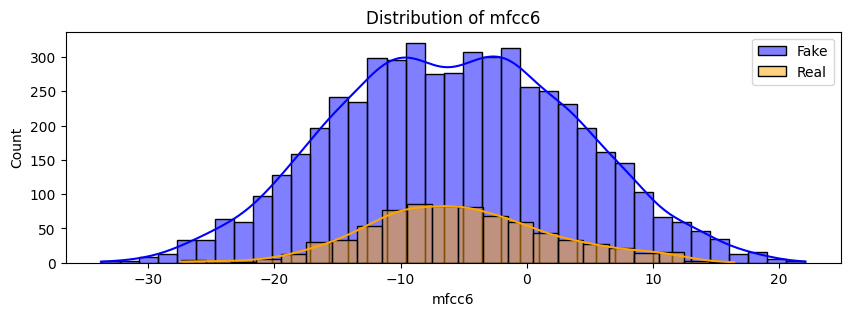

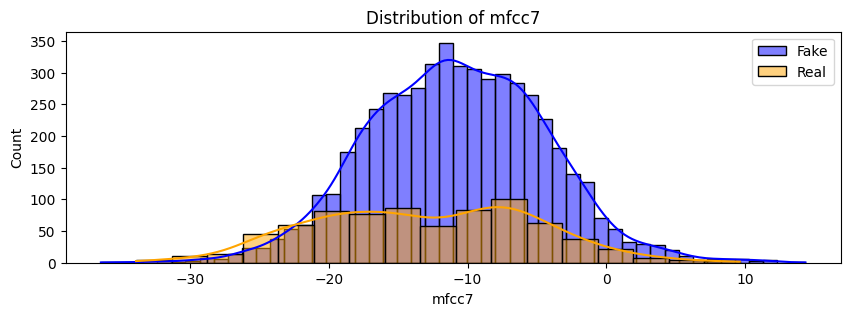

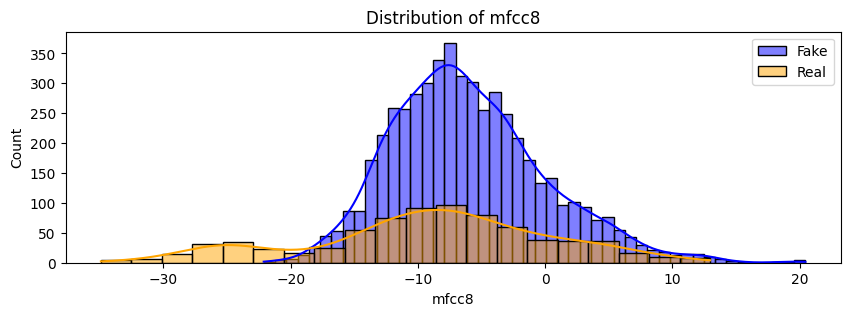

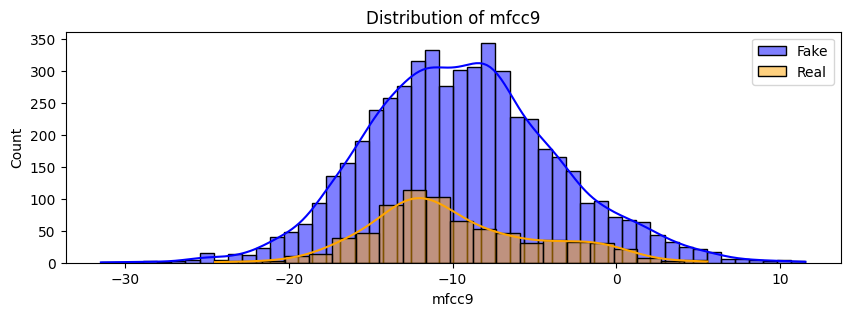

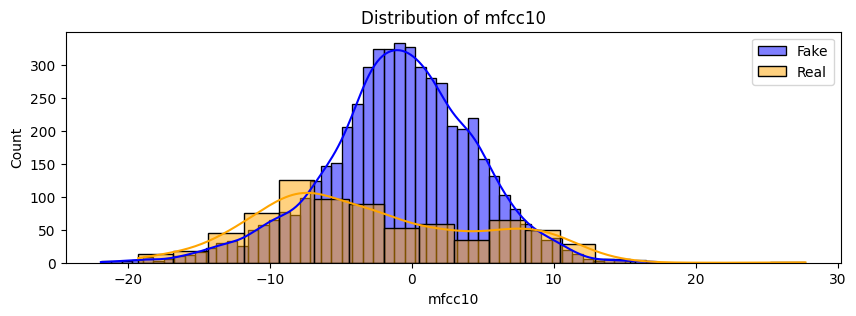

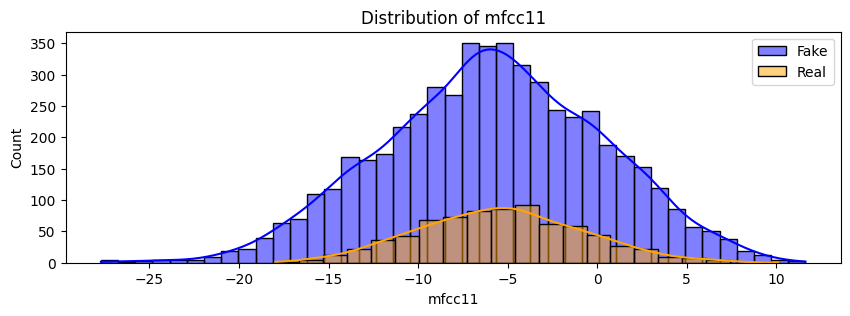

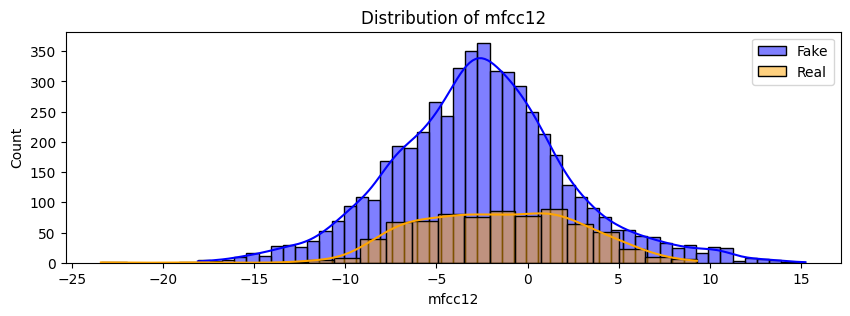

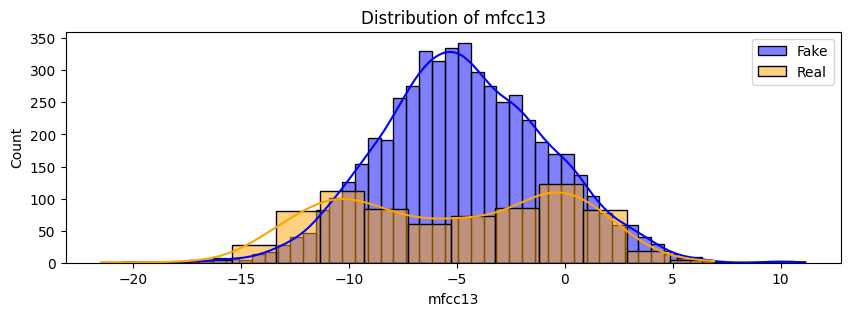

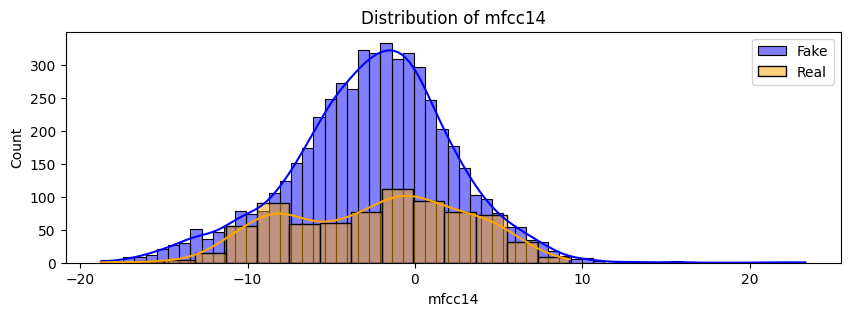

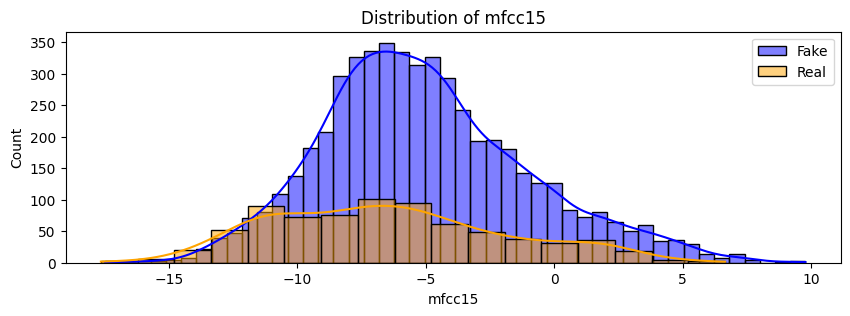

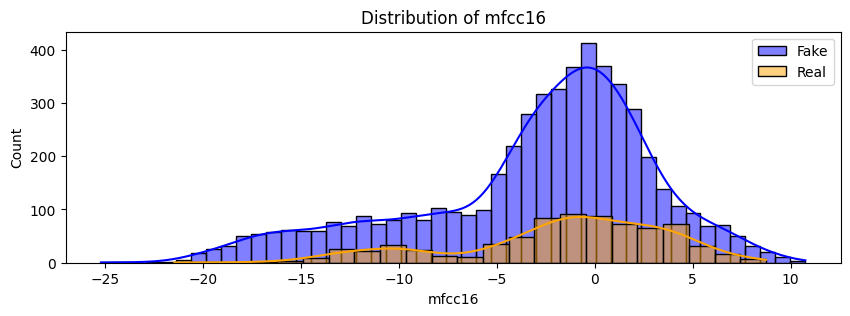

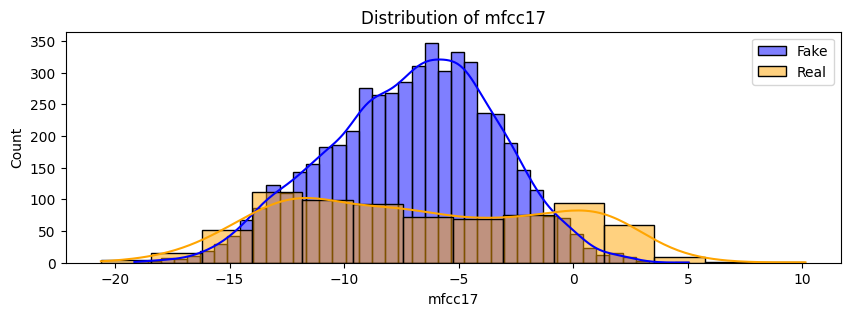

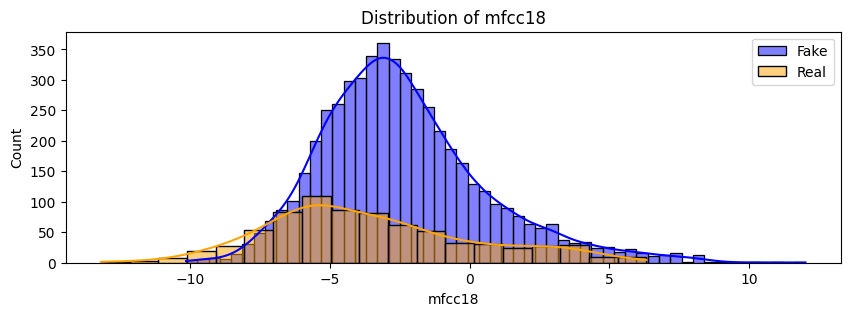

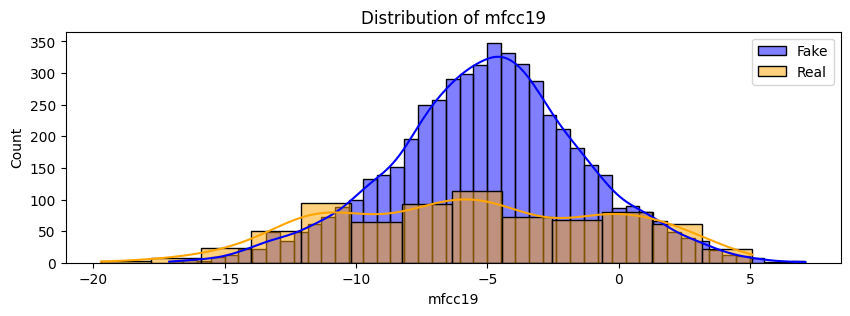

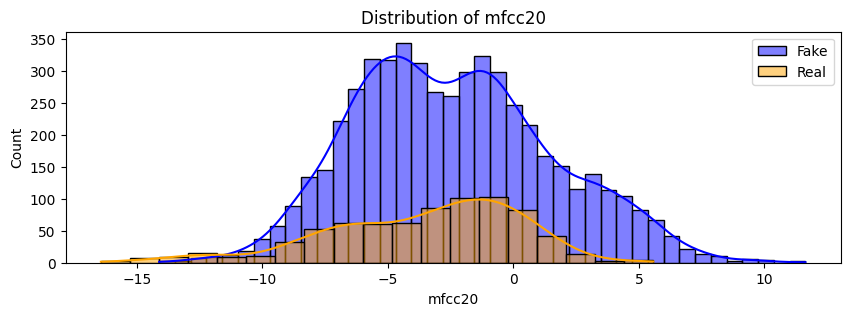

In [117]:
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
for column in list(df)[:-2]:
    plt.figure(figsize=(10, 3))
    sns.histplot(df[df['LABEL'] == 'FAKE'][column], kde=True, label='Fake', color='blue')
    sns.histplot(df[df['LABEL'] == 'REAL'][column], kde=True, label='Real', color='orange')
    plt.title(f'Distribution of {column}')
    plt.legend()
    plt.show()

Видим что распределения фичей фейковых и реальных в целом отличаются и это означает, что по нашим данным можно постротить хорошие модели. Также по графичкам видно, что у нас нет данных, которые можно однозначно считать выбросами

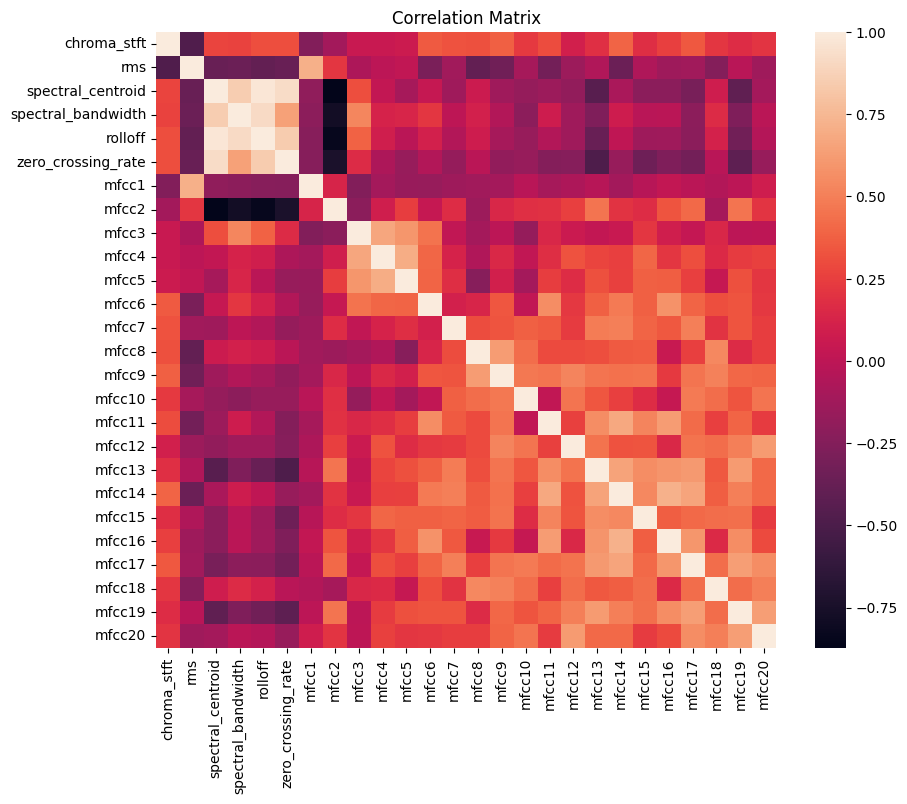

In [120]:
correlation_matrix = df.iloc[:, :-2].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix)
plt.title('Correlation Matrix')
plt.show()

Видно, что нет очень сильной корреляции между призанки в основном это 0.5 или ниже. 

# Борьба с дисбалансом классов

In [10]:
# Видно что явный дисбаланс классов, поэтому нужно сбалансировать их
df['LABEL'] = df['LABEL'].apply(lambda x: find_index(x))
df['LABEL'].value_counts()

LABEL
0    5250
1     755
Name: count, dtype: int64

Возьмем из каждого аудиофайла из класса Fake равное количиество сегментов так, чтобы в сумме получилось количество сегментов, как у класса Real

In [11]:
all_fake = df[df['LABEL'] == 0]['origin_sample'].unique()
cnt_fake_i = (df[df['LABEL'] == 1].shape[0] + all_fake.shape[0] - 1 ) // all_fake.shape[0]
cnt_fake_i

14

In [12]:
new_df = pd.DataFrame()
for val in all_fake:
    new_df = pd.concat([df[(df['LABEL'] == 0) & (df['origin_sample'] == val)].sample(cnt_fake_i, random_state=1337), new_df])
new_df = pd.concat([new_df, df[(df['LABEL'] == 1)]]).reset_index(drop=True)
df = new_df.copy()

In [13]:
df['LABEL'].value_counts() # Теперь у нас сбалансированный набор

LABEL
0    784
1    755
Name: count, dtype: int64

In [14]:
X, y = df.drop(['origin_sample', 'origin_sample'], axis=1).iloc[:, :-1], df.drop('origin_sample', axis=1).iloc[:, -1]

In [15]:
# функция для оценки качества моделей

def calc_metrics(y_true, y_pred):
    try:
        rec = recall_score(y_true , y_pred.argmax(axis=1))
        f1 = f1_score(y_true , y_pred.argmax(axis=1))
        mcc = matthews_corrcoef(y_true , y_pred.argmax(axis=1))
        roc = roc_auc_score(y_true , y_pred[:, 1])
        acc = accuracy_score(y_true, y_pred.argmax(axis=1))
        pr = precision_score(y_true, y_pred.argmax(axis=1))
        return {'rec': rec, 'pr': pr, 'f1': f1, 'mcc': mcc, 'roc': roc, 'acc': acc}
    except:
        return None

# Разбиение на тестовую и тренировочную выборку

In [16]:
X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(), pd.Series()

Сделаем две отдельные выборки для каждого из классов, чтобы в тестовом и в тренриовочном наборе данных у нас были представлены два класса. Мы получаем Stratified Group1Fold

In [17]:
real_samples = np.array(df.loc[df['LABEL'] == 1,'origin_sample'].unique())
fake_samples = np.array(df.loc[df['LABEL'] == 0,'origin_sample'].unique())
real_samples

array(['biden-original', 'trump-original', 'taylor-original',
       'obama-original', 'margot-original', 'linus-original',
       'musk-original', 'ryan-original'], dtype=object)

In [18]:
real_samples = shuffle(real_samples, random_state=1337) # перемешаем набор источников семплов, чтобы всё было честно
fake_samples = shuffle(fake_samples, random_state=1337)
real_samples

array(['musk-original', 'taylor-original', 'trump-original',
       'obama-original', 'biden-original', 'margot-original',
       'linus-original', 'ryan-original'], dtype=object)

In [19]:
test_size = 0.15
for sample_arr in [real_samples, fake_samples]:
#     print(len(real_samples) * (1 - test_size), len(real_samples))
    for i, sample_name in enumerate(sample_arr):
        # Из каждого файла добавляем все сегменты либо в тестовую выборку, либо в тренировочную.
        # Пока тренировочная не достигла максимального размера добавляем туда, иначе в тестовую
        if i < len(sample_arr) * (1 - test_size):
            X_train = pd.concat([df.loc[df['origin_sample'] == sample_name].drop(['LABEL', 'origin_sample'], axis=1), X_train]).reset_index(drop=True)
            y_train = pd.concat([df.loc[df['origin_sample'] == sample_name, 'LABEL'], y_train]).reset_index(drop=True)
        else:
            X_test = pd.concat([df.loc[df['origin_sample'] == sample_name].drop(['LABEL', 'origin_sample'], axis=1), X_test]).reset_index(drop=True)
            y_test = pd.concat([df.loc[df['origin_sample'] == sample_name, 'LABEL'], y_test]).reset_index(drop=True)

/tmp/ipykernel_33/3538218230.py:7: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_train = pd.concat([df.loc[df['origin_sample'] == sample_name, 'LABEL'], y_train]).reset_index(drop=True)
/tmp/ipykernel_33/3538218230.py:10: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_test = pd.concat([df.loc[df['origin_sample'] == sample_name, 'LABEL'], y_test]).reset_index(drop=True)


In [20]:
X_train.shape[0], X_test.shape[0] # Рамерность тестовой выборки получилась примерно 10% от исходной

(1408, 131)

Добавим стартовые параметры для моделей

In [90]:
models_params = [{'n_neighbors': 6},
                 {'n_estimators': 1000, 'random_state': 1, 'max_depth': 10, 'verbose': 0, 'class_weight': 'balanced'},
                {'random_state': 7575, 'class_weight' : 'balanced', 'max_iter' : 6000, 'C' : 0.01}, 
                {'iterations': 1000, 'learning_rate': 1, 'depth': 3, 'verbose': 0},
                {'max_depth': 10}, {'max_depth': 10, 'n_estimators': 1000}, {'max_iter': 2000}]
                          
models = [KNeighborsClassifier, RandomForestClassifier, LogisticRegression, CatBoostClassifier, DecisionTreeClassifier, ExtraTreesClassifier, MLPClassifier]

In [100]:
res = pd.DataFrame(columns = list(calc_metrics(pd.Series([0, 1]), np.array([[0.4, 0.4], [0.4, 0.6]])).keys()) + ['model_name', 'fit time sec'])
for i, model_i in enumerate(models):
    model = model_i(**models_params[i])
    time_start = time()
    model.fit(X_train, y_train)
    time_end = time()
    pred_values = model.predict_proba(X_test)
    metrics = calc_metrics(y_test, pred_values)
    res.loc[len(res)] = list(metrics.values()) + [model_i.__name__, time_end - time_start]
res

rec        pr        f1       mcc       roc       acc  \
0  0.263158  0.147059  0.188679  0.003397  0.499530  0.671756   
1  1.000000  0.730769  0.844444  0.827705  0.999060  0.946565   
2  0.947368  0.346154  0.507042  0.463361  0.851034  0.732824   
3  1.000000  0.863636  0.926829  0.916790  1.000000  0.977099   
4  1.000000  0.527778  0.690909  0.669080  0.881109  0.870229   
5  0.947368  0.642857  0.765957  0.737085  0.982613  0.916031   
6  1.000000  0.240506  0.387755  0.334161  0.784774  0.541985   

               model_name  fit time sec  
0    KNeighborsClassifier      0.002150  
1  RandomForestClassifier      5.981399  
2      LogisticRegression      0.546569  
3      CatBoostClassifier      1.697532  
4  DecisionTreeClassifier      0.036928  
5    ExtraTreesClassifier      2.077465  
6           MLPClassifier      0.366126

Самой важной метрикой является f1 score поскольку он учитывает precision и recall, а также roc-auc поскольку это весьма устойчивая метрика, которая часто применяется в качестве финальной оценкий модели

Самый перспективной моделью по начальным параметрам оказался CatBoost Classifier,
поэтому будем использовать эту модель в качестве основной

## Отбор лучших параметров

In [63]:
model = CatBoostClassifier(verbose=0)

In [64]:
# Определяем сетку параметров для поиска
parameters = {'depth'         : [2, 3, 4, 5],
              'learning_rate' : [0.4, 0.6, 1],
              'iterations'    : [100, 500, 1000, 2000, 3000]
              }

# Создаем экземпляр GridSearchCV
grid = GridSearchCV(estimator=model, param_grid = parameters, n_jobs=-1)
grid.fit(X_train, y_train)

# Выводим лучшие параметры
print("Лучшие параметры: ", grid.best_params_)

Лучшие параметры:  {'depth': 3, 'iterations': 3000, 'learning_rate': 1}


# Финальные результаты

In [99]:
%%time
model = CatBoostClassifier(**grid.best_params_, verbose=1000)
model.fit(X_train, y_train)

0:	learn: 0.4700698	total: 2.04ms	remaining: 6.11s
1000:	learn: 0.0013950	total: 1.52s	remaining: 3.04s
2000:	learn: 0.0012209	total: 3.03s	remaining: 1.51s
2999:	learn: 0.0011412	total: 4.52s	remaining: 0us
CPU times: user 14.6 s, sys: 2.11 s, total: 16.7 s
Wall time: 4.76 s


In [81]:
y_pred = model.predict_proba(X_test)

In [85]:
for key, value in calc_metrics(y_test, y_pred).items():
    print(f'{key}: {value}')

rec: 1.0
pr: 0.8636363636363636
f1: 0.9268292682926829
mcc: 0.9167896414953906
roc: 1.0
acc: 0.9770992366412213


Отличные метрики на тестовой выброке, которые говорят о высоком качестве модели.

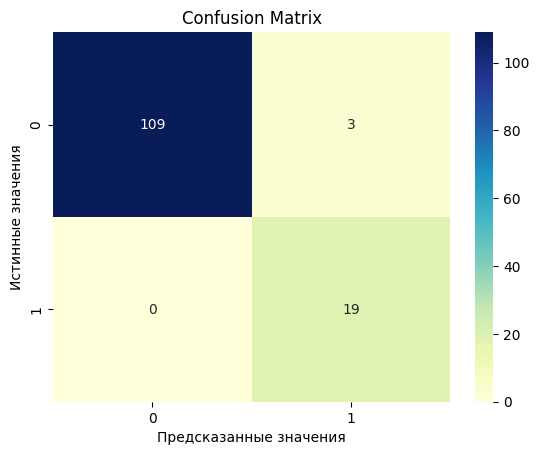

In [87]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))

# Plot confusion matrix using seaborn
sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu", fmt='d')
plt.title("Confusion Matrix")
plt.ylabel("Истинные значения")
plt.xlabel("Предсказанные значения")
plt.show()

Мы можем весьма хорошо предсказывать оба класса и отличать фейковую запись от реальной. Поэтому нам нет необходимости строить другую модель или делать какой-то ансамбль, наша модель и так хорошо справляется с задачей. 

# Выводы

В ходе исследования была разработана и обучена модель машинного обучения для идентификации личности по голосу. Модель была обучена на датасете, включающем в себя реальные голоса и голоса, сгенерированные нейронной сетью. 

Результаты показали, что модель способна с высокой точностью отличать реальные голоса от сгенерированных, при этом не тратя много времени на обучение и предсказание. Это подтверждает, что машинное обучение может быть эффективно использовано в задачах идентификации личности по голосу. 

Однако, стоит отметить, что качество модели в значительной степени зависит от качества и объема обучающих данных. В нашем случае, модель была обучена на не очень большом, но разнообразном датасете.

Также важно учесть, что модель может испытывать трудности при работе с голосами, которые сильно отличаются от тех, на которых она была обучена. Это может быть проблемой при работе с голосами людей разных возрастов, полов или национальностей.

**Выводы**: Машинное обучение представляет большой потенциал для идентификации личности по голосу. Однако, для достижения наилучших результатов, важно иметь доступ к большому и разнообразному набору обучающих данных. Также необходимо учесть, что модель может испытывать трудности при работе с голосами, которые сильно отличаются от тех, на которых она была обучена.